# Reaction Analysis - Database Design
## Andy Kamath, Kyle Into, Kyle Chu, Keith Cestaro, Suraj Korumilli

In this project, we aim to analyze Facebook reactions on politically affiliated news channels to see how people react to different content across the political spectrum. As can later be seen, things like "Trump" tend to garner a lot of reactions, but from left-leaning sites, these tend to be primarily Sad/Angry reacts, while on right-leaning sites, they tend to be Love/Wow or even Angry reacts as well. We wanted to explore this more, so we present these findings. 

In [133]:
# All of these are installable via pip (except creds - those are the credentials to access our database)
import pandas as pd
import nltk
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import MySQLdb as sql
import numpy as np
from random import shuffle
from creds import Creds

## Connect to our database and fetch our data
Below is our entity relationship diagram. One thing we wanted to point out as a design choice was that we decided to **create our own reactions table as opposed to making them columns.** This was because Facebook tends to beta test reactions from time to time, as well as add reactions at certain times, like thankful reacts during Thanksgiving, or Pride reacts to support the LGBT community. If we were to make all our reactions as columns in one table, it would greatly reduce our scalability as we add more data. 

In our code below, we fetch all relevant data from our table and then proceed to manipulate it later on using the Pandas library as opposed to dozens of SQL queries. This was due to how powerful the Pandas library is and dataframes are, and also to reduce computational load on our servers; we are on a free trial on Google Cloud and did not want to risk having long-lasting connections simultaneously and get billed for it.

![er.png](er.png)

In [42]:
# Data preprocessing
conn = creds.connect()

# Python code to fetch data from the MySQL database
c = Creds()

# Connect to the database
conn = sql.connect(host=c.host(), database=c.db(), user=c.dbUser(), password=c.dbPass())
cursor = conn.cursor()

# Fetch the results from the database given a query and load them into Pandas
def get_results(query):
    cursor.execute(query)
    conn.commit()
    data = cursor.fetchall()
    df = pd.read_sql(query, con=conn)
    return df

df = get_results('''
    select a.name as 'source', 
        p.text_content as 'content', 
        pr.reaction_count
        r.reaction_type as 'reaction', 
    from post p
    join author a using(author_id)
    join postreaction pr using(post_id)
    join reaction r using(reaction_id)
''')

# Display the last ten results
df.head(10)

,source,content,reaction_count,reaction
265,Occupy Democrats,This is why we say he's NOT our president!,5.0,Love
908,NPR,The final Senate election of 2018 was long see...,5800.0,Sad
1035,Breitbart,LIVE: President and Melania Trump Light the Na...,7.0,Sad
35,CNN,President Trump's answers to special counsel R...,1009.0,Like
597,NRA,NRA is proud to introduce Mossy Oak as our off...,7.0,Haha
25,NPR,Everything from licensing their logos to offer...,158.0,Like
809,Occupy Democrats,Make America Great - Lock him up!,41.0,Angry
153,Breitbart,“There is no tomorrow on this. Republicans are...,539.0,Like
942,NRA,A sitting Congressman suggested that the feder...,6600.0,Sad
60,NRA,“The NRA is the only organization in America t...,19000.0,Like


In [84]:
# Names of the distinct sources
sources = df['source'].unique()
sources

array(['NPR', 'CNN', 'NRA', 'Occupy Democrats', 'Fox News', 'Breitbart'],
      dtype=object)

## Word Frequency Analysis
First, we used a wordcloud library to generate visualizations of the most used words per source. The bigger the word in the wordcloud, the more frequently it is used in the source.

To build further on this, we wanted to extract the most important and most used words, so we used the NLTK library to do this. NLTK is the Python NLP Library. We used their speech tagging functions to identify the parts of speech
of different words in our post corpus. Using this, we can filter out insignificant words like prepositions and
articles and keep all the words we use relevant to our study

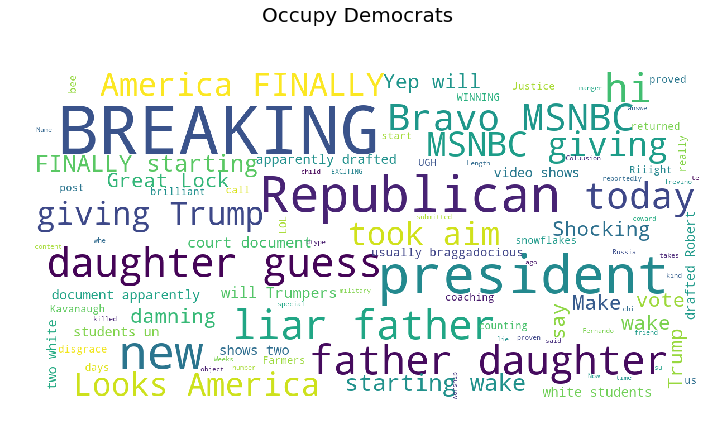

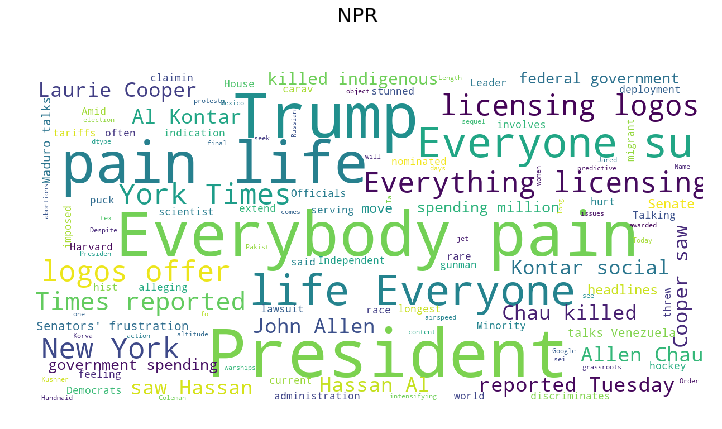

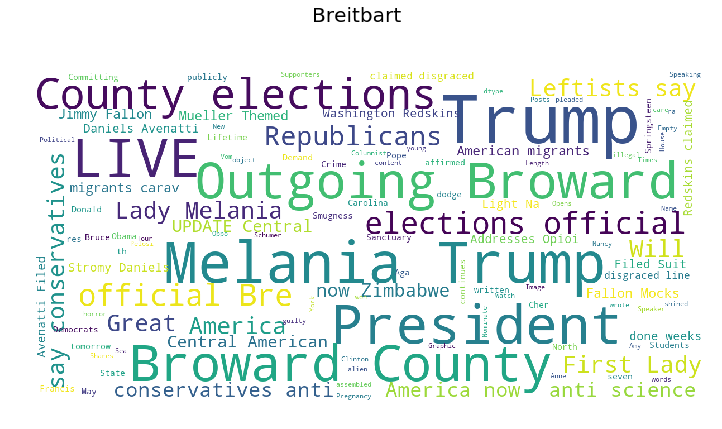

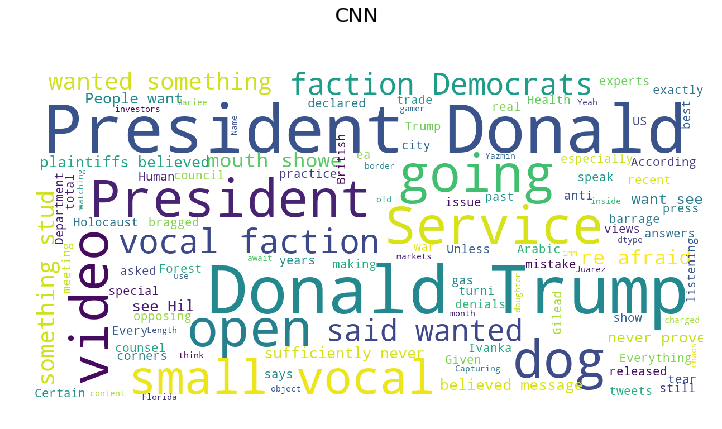

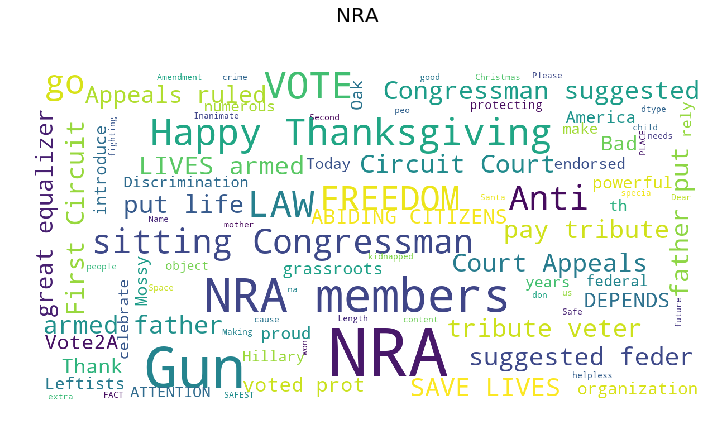

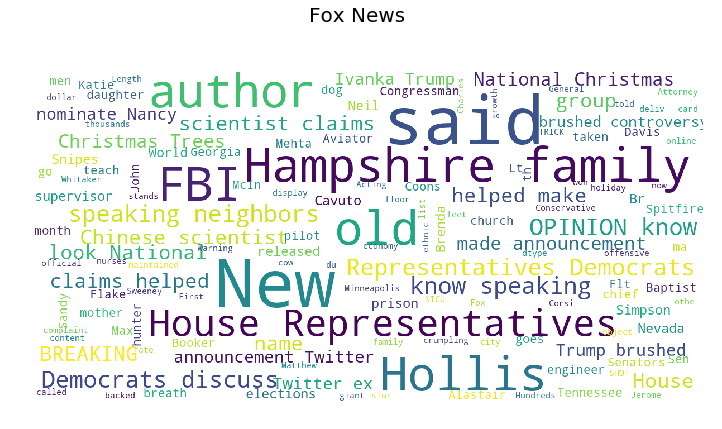

In [47]:
# A set of words that don't carry much significance 
stopwords = set(STOPWORDS)

# Function to use the wordcloud library and plot the result in PyPlot
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=1.3)

    plt.imshow(wordcloud)
    plt.show()

for source in sources:
    show_wordcloud(df.loc[df['source'] == source]['content'], source)

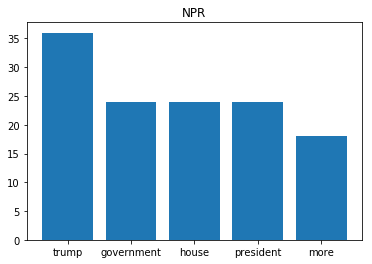

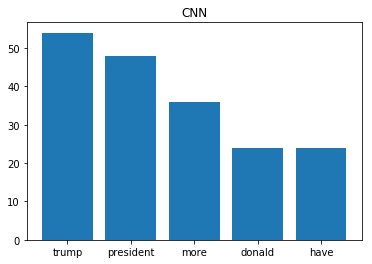

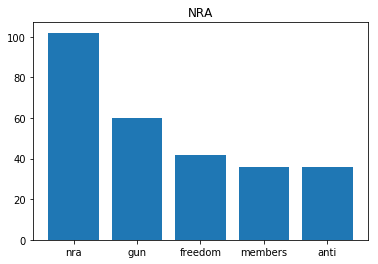

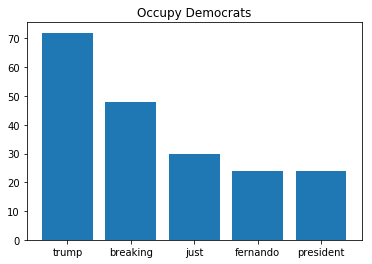

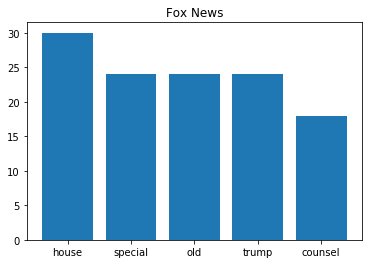

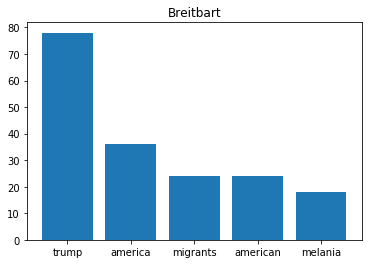

In [109]:
# Parts of speech to ignore
pos_to_ignore = ['CC', 'IN', 'POS', 'TO', 'DT', 'WDT', 'VBN', 'PRP$', 'PRP', 'VBD', 'MD', 'WP', 'EX', 'VBZ', 'WRB']

# Words to ignore
words_to_ignore = ['are']

# Common Words dictionary
common_words = {source: {} for source in sources}

for source, content in zip(df['source'], df['content']):
    # Tokenize each post into a list of lowercase words
    wordList = list(map(lambda x: x.lower(), re.sub("[^\w]", " ",  content).split()))
    tokens = nltk.word_tokenize(' '.join(wordList))

    # Remove the words that we want to ignore based on the lists created above
    tagged = list(filter(lambda x: x[1] not in pos_to_ignore 
                         and x[0] not in words_to_ignore 
                         and len(x[0]) > 2, 
                         nltk.pos_tag(tokens)))
    wordList = tagged
    wordList = list(map(lambda x: x[0], tagged))
    
    # Remove duplicate words within the post
    wordList = set(wordList)
    
    for word in wordList:
        # For every word occurrence, increment the count by 1
        if word not in common_words[source]:
            common_words[source][word] = 0
        common_words[source][word] += 1
    
# Plot the top five words per source 
for source in sources:
    sorted_by_value = list(filter(lambda x: x[1] > 1, sorted(common_words[source].items(), key=lambda kv: kv[1])[::-1]))
    x, y = zip(*sorted_by_value[:5])
    plt.bar(x, y)
    plt.title(source)
    #plt.yticks([])
    plt.show()

## Reaction Analysis
Here, we attempt to see how audiences tend to react to different news channels in general. As we can see, left-leaning sites predominantly garner Angry, Haha, or Sad reactions because these channels post material that goes against the current right-wing government. Similarly, right-leaning sites get Love, Angry, and Haha because they are mocking the other party and in favor of the current government.

In the first cell, we include likes primarily just to show that likes tend to be the dominant reaction, except in NPR and Breitbart, where the dominant reactions were Angry and Haha - more so than likes. This was interesting considering that Likes tend to be the far most predominant reaction since it is the most convenient and doesn't require an additional step to add an actual reaction. In the next cell, we exclude likes because they manifest themselves as irrelevant and ambiguous data.

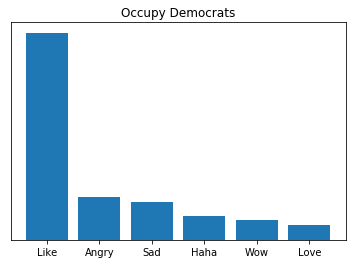

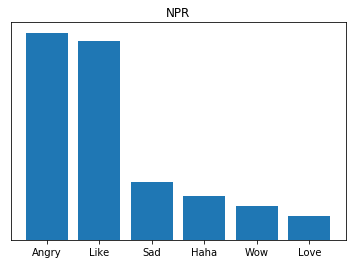

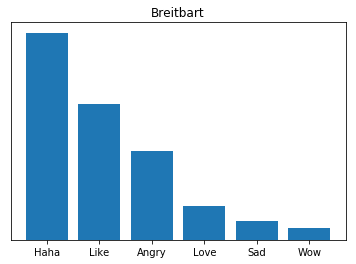

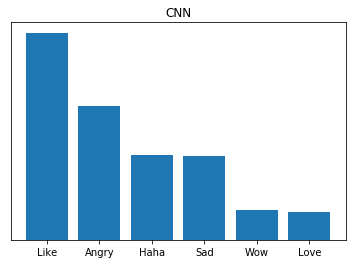

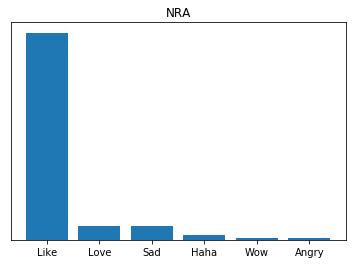

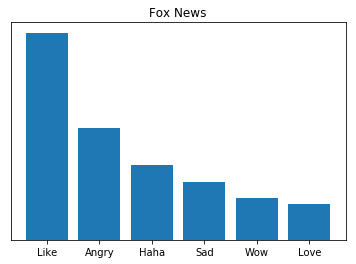

In [63]:
# List of unique reactions
reactions = df['reaction'].unique()

# Build a reaction dictionary that links sources to reactions
reactiondict = {source: {} for source in sources}

# Link each source to reactions and reaction counts
for source in sources:
    vals = {r: 0 for r in reactions}
    sourced = df.loc[df['source'] == source]
    for r in reactions:
        vals[r] = sum(sourced.loc[sourced['reaction'] == r]['reaction_count'])
    reactiondict[source] = vals

# Loop through this dictionary's items to plot the most used reactions on every page
for source, val in reactiondict.items():
    sorted_by_value = list(filter(lambda x: x[1] > 1, sorted(val.items(), key=lambda kv: kv[1])[::-1]))
    x, y = zip(*sorted_by_value)
    plt.bar(x, y)
    # Remove y-axis labels to make it cleaner - big numbers become insignificant and messy
    plt.yticks([])
    plt.title(source)
    plt.show()

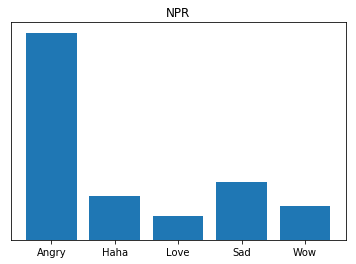

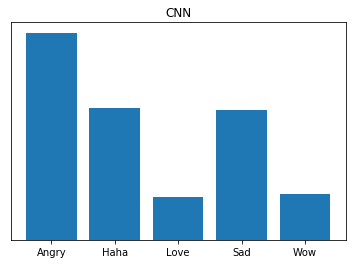

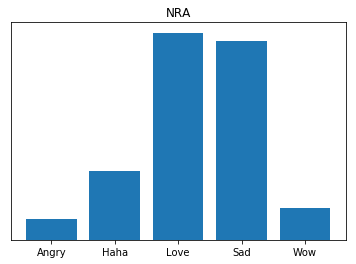

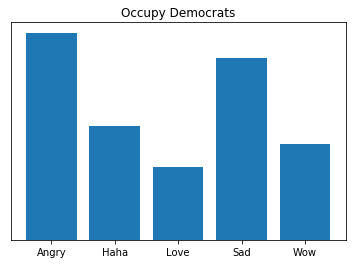

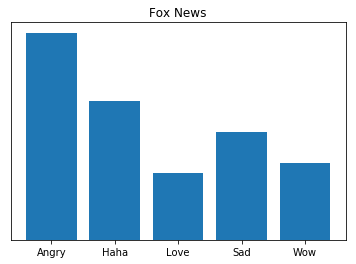

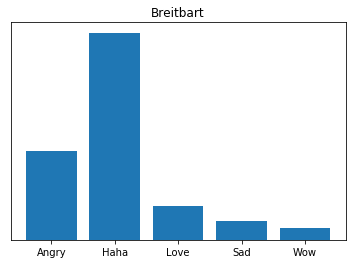

In [89]:
# Limit the reactions to just the most common ones and excluding likes
reactions = ['Love', 'Wow', 'Haha', 'Angry', 'Sad']

# Rebuild the source-to-reaction dictionary and apply the same logic but with a smaller reaction set
reactiondict = {source: {} for source in sources}
for source in sources:
    vals = {r: 0 for r in reactions}
    sourced = df.loc[df['source'] == source]
    for r in reactions:
        vals[r] = sum(sourced.loc[sourced['reaction'] == r]['reaction_count'])
    reactiondict[source] = vals

# Graph the most common reactions per page
for source, val in reactiondict.items():
    # Sort in alphabetical order by reaction so as to keep graphs consistent
    sorted_by_value = list(filter(lambda x: x[1] > 1, sorted(val.items(), key=lambda kv: kv[0])))
    x, y = zip(*sorted_by_value) 
    plt.bar(x, y)
    # Remove y-axis labels to make it cleaner - big numbers become insignificant and messy
    plt.yticks([])
    plt.title(source)
    plt.show()

## Word-Reaction Analysis
Now that we have seen the words that tend to be used by different news streams and how people react to news channels in general, we can try to relate the two and see what words cause what reactions on what pages. This is super interesting because Trump was mentioned across all channels and was very frequent, but needless to say, different people will have very different reactions to such a polarizing figure. 

First, we create a dictionary called common_words that finds the reactions per word per source, and then we have another dictionary that aggregates the reactions per word across all sources. In this manner, we can see how specifically people react to specific words on a specific channel as well as how people in general view certain topics.

In [119]:
# Link words to reactions per page
common_words = {source: {} for source in sources}

posts = df['content'].unique()

# Much like earlier, isolate words in each post, but this time, also find the reactions per word
for content in posts:
    # Create a dictionary to easily access reaction counts
    vals = df.loc[df['content'] == content][['source', 'reaction', 'reaction_count']].set_index('reaction').to_dict('index')
    # Kinda convoluted but this is how you can get the source
    source = vals['Like']['source']
    # List of words used in the post
    wordList = list(map(lambda x: x.lower(), re.sub("[^\w]", " ",  content).split()))
    tokens = nltk.word_tokenize(' '.join(wordList))
    # Filter the list of words so it's not in the parts of speech or words to ignore list
    wordList = filter(lambda x: x[1] not in pos_to_ignore 
                         and x[0] not in words_to_ignore 
                         and len(x[0]) > 2, 
                         nltk.pos_tag(tokens))
    wordList = list(map(lambda x: x[0], wordList))
    
    # For each word, find the reaction count for that post and add it to the reaction count
    # in the dictionary of words
    for word in wordList:
        if word not in common_words[source]:
            common_words[source][word] = {r : 0 for r in reactions}            
        for r in reactions:
            common_words[source][word][r] += vals[r]['reaction_count']

# Calculate total reaction counts per word
for source in sources:
    for key, val in common_words[source].items():
        common_words[source][key]['total'] = sum([common_words[source][key][r] for r in reactions])

# Isolate five random words used by NPR as a sample for the dictionary structure
rands = list(common_words['NPR'].items())
shuffle(rands)
rands[:5]

[('sanders',
  {'Love': 1000.0,
   'Wow': 37.0,
   'Haha': 201.0,
   'Angry': 123.0,
   'Sad': 15.0,
   'total': 1376.0}),
 ('alone',
  {'Love': 58.0,
   'Wow': 2.0,
   'Haha': 3.0,
   'Angry': 1.0,
   'Sad': 0.0,
   'total': 64.0}),
 ('lawyer',
  {'Love': 11.0,
   'Wow': 157.0,
   'Haha': 281.0,
   'Angry': 1200.0,
   'Sad': 22.0,
   'total': 1671.0}),
 ('jet',
  {'Love': 0.0,
   'Wow': 66.0,
   'Haha': 0.0,
   'Angry': 110.0,
   'Sad': 123.0,
   'total': 299.0}),
 ('out',
  {'Love': 1.0,
   'Wow': 41.0,
   'Haha': 12.0,
   'Angry': 16.0,
   'Sad': 36.0,
   'total': 106.0})]

In [123]:
# Same logic as above, but this time isolate the total words across all sources and find total reactions

words_isolated = {}

for content in posts:
    vals = df.loc[df['content'] == content][['source', 'reaction', 'reaction_count']].set_index('reaction').to_dict('index')
    source = vals['Like']['source']
    wordList = list(map(lambda x: x.lower(), re.sub("[^\w]", " ",  content).split()))
    tokens = nltk.word_tokenize(' '.join(wordList))
    tagged = list(filter(lambda x: x[1] not in pos_to_ignore and x[0] not in words_to_ignore and len(x[0]) > 2, nltk.pos_tag(tokens)))
    wordList = tagged
    wordList = list(map(lambda x: x[0], tagged))
    for word in wordList:
        if word not in words_isolated:
            words_isolated[word] = {r : 0 for r in reactions}            
        for r in reactions:
            words_isolated[word][r] += vals[r]['reaction_count']
            
# Calculate total reaction counts per word
for source in sources:
    for key, val in words_isolated.items():
        words_isolated[key]['total'] = sum([words_isolated[key][r] for r in reactions])

# Another sample of five words used across all sources and the total reactions they garnered
rands = list(words_isolated.items())
shuffle(rands)
rands[:5]

[('hathaway',
  {'Love': 12.0,
   'Wow': 136.0,
   'Haha': 4300.0,
   'Angry': 776.0,
   'Sad': 39.0,
   'total': 5263.0}),
 ('gold',
  {'Love': 2.0,
   'Wow': 9.0,
   'Haha': 27.0,
   'Angry': 114.0,
   'Sad': 16.0,
   'total': 168.0}),
 ('ineffective',
  {'Love': 1000.0,
   'Wow': 37.0,
   'Haha': 201.0,
   'Angry': 123.0,
   'Sad': 15.0,
   'total': 1376.0}),
 ('rather',
  {'Love': 37.0,
   'Wow': 38.0,
   'Haha': 22.0,
   'Angry': 1200.0,
   'Sad': 123.0,
   'total': 1420.0}),
 ('fictional',
  {'Love': 291.0,
   'Wow': 223.0,
   'Haha': 7.0,
   'Angry': 1.0,
   'Sad': 1.0,
   'total': 523.0})]

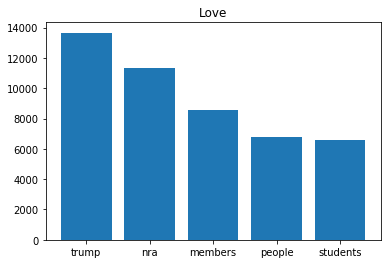

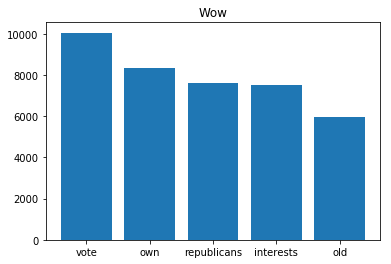

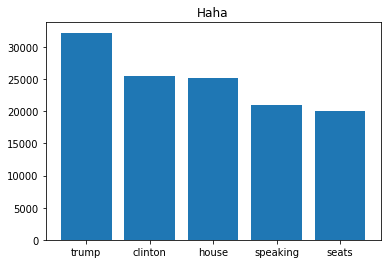

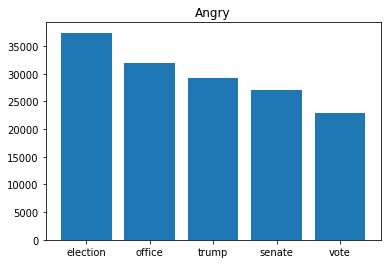

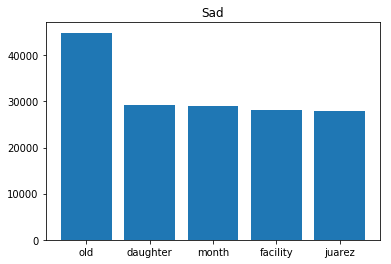

In [124]:
# Across ALL sources, how much do people react to certain words?
for r in reactions:
    react = sorted([(word, reaction[r]) for word, reaction in words_isolated.items()], key=lambda x: x[1])[::-1]
    x, y = zip(*react[:5])
    plt.bar(x, y)
    plt.title(r)
    plt.show()

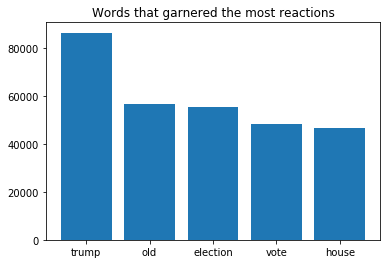

In [128]:
# Across ALL sources, what words caused the most reactions from its audiences?
r = 'total'
react = sorted([(word, reaction[r]) for word, reaction in words_isolated.items()], key=lambda x: x[1])[::-1]
x, y = zip(*react[:5])
plt.bar(x, y)
plt.title('Words that garnered the most reactions')
plt.show()

## Slight disclaimer
In the cell below, we attempt to tie words to reactions per page, but on posts that gained a lot of reactions in general, this task became quite difficult to analyze because certain posts garnered a lot of reactions that made one word outweigh a lot of the other words used for that reaction. Typically this was because that specific reaction was not used very much by the source in general. 

Also words that tend to go together outweighed other ones too, like "president" and "donald" with "trump." We did our best to show the most interesting graphs on the presentation, but obviously all our graphs are present here.

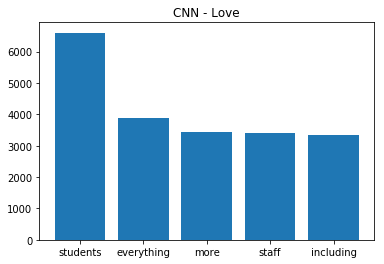

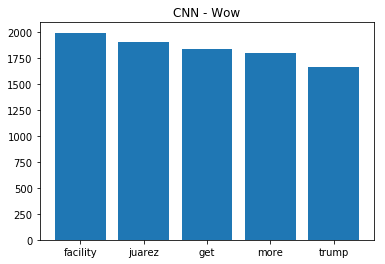

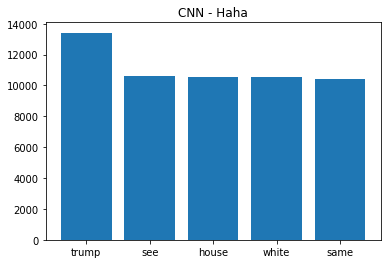

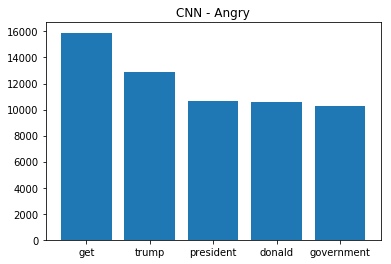

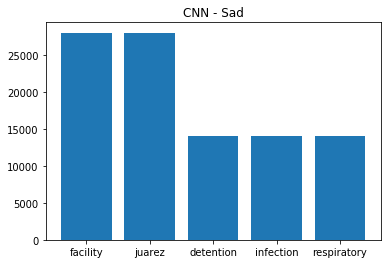

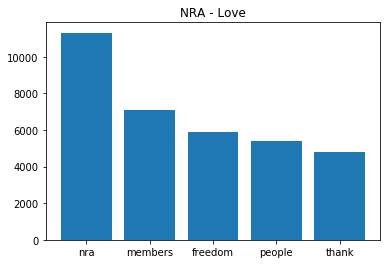

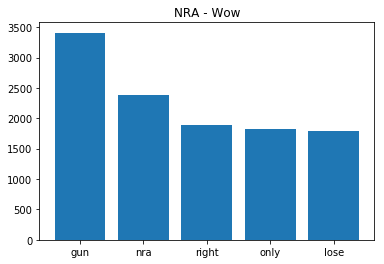

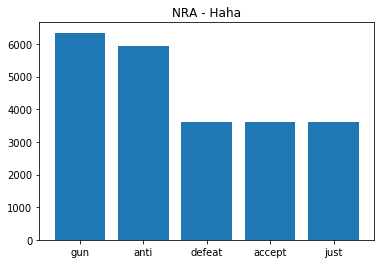

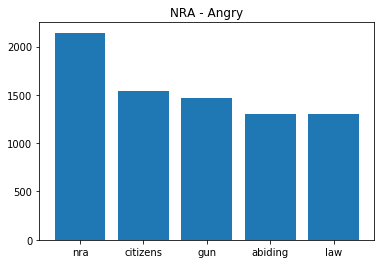

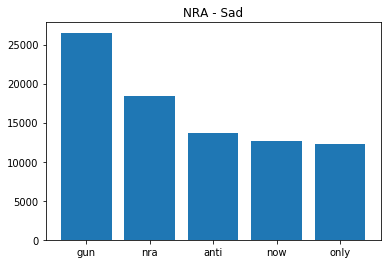

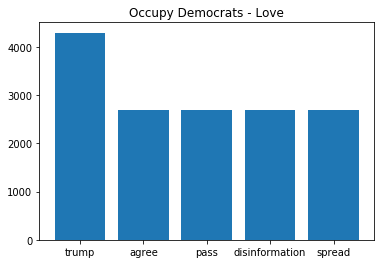

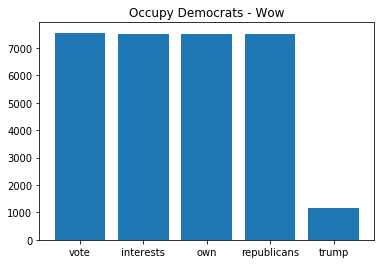

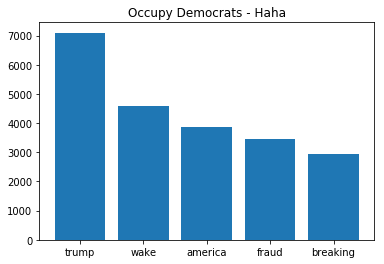

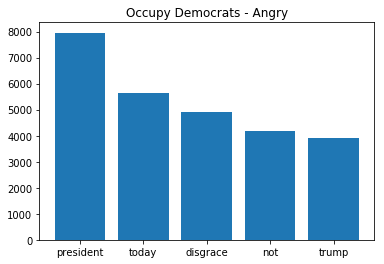

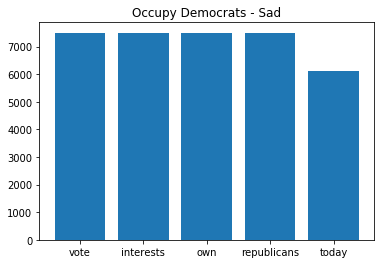

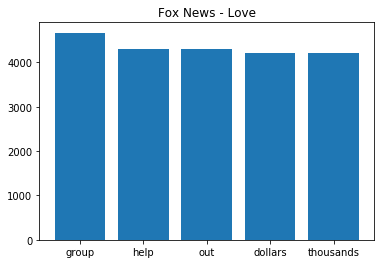

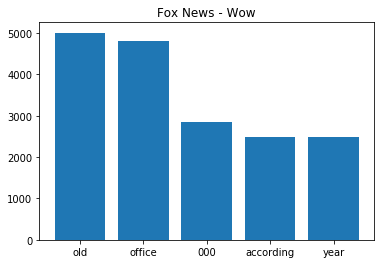

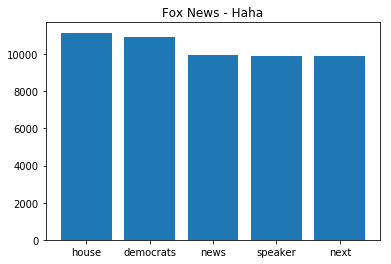

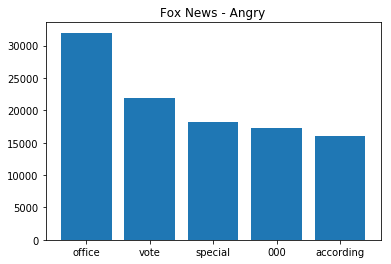

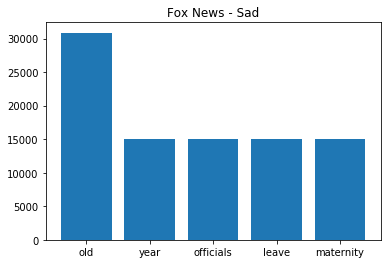

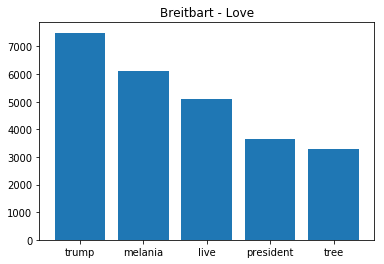

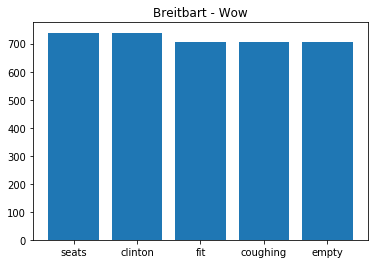

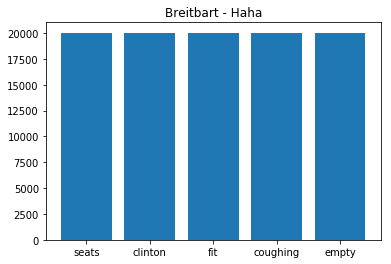

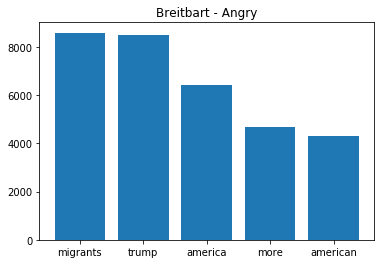

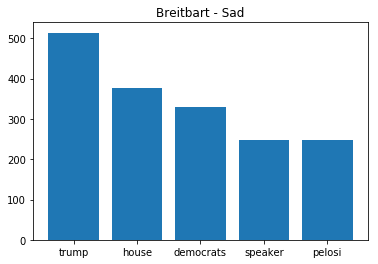

In [130]:
# Can we see how much people react to words on specific pages?
for source in sources:
    for r in reactions:
        react = sorted([(word, reaction[r]) for word, reaction in common_words[source].items()], key=lambda x: x[1])[::-1]
        x, y = zip(*react[:5])
        plt.bar(x, y)
        plt.title(source+" - "+r)
        plt.show()

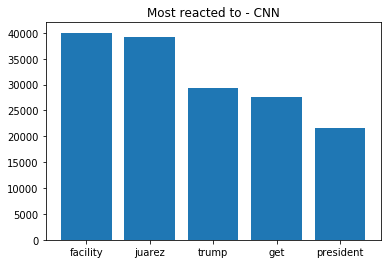

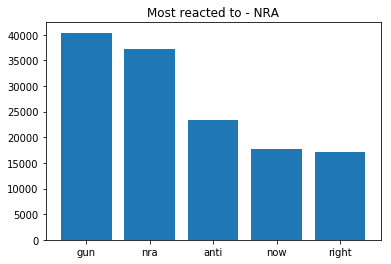

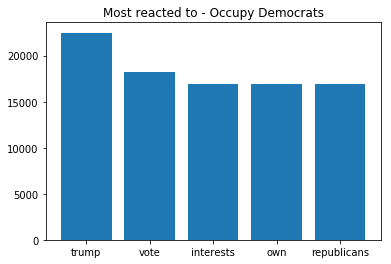

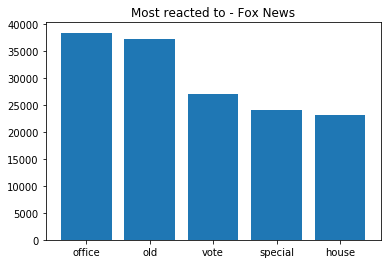

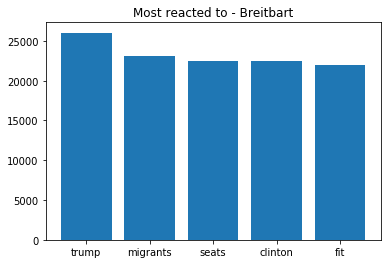

In [131]:
# Can we see how much people react to words on specific pages?
for source in sources:
    r = 'total'
    react = sorted([(word, reaction[r]) for word, reaction in common_words[source].items()], key=lambda x: x[1])[::-1]
    x, y = zip(*react[:5])
    plt.bar(x, y)
    plt.title(f'Most reacted to - {source}')
    plt.show()